# Stacked GRU Cells for Classification of Quantum Measurements
Due credit to Théau Peronnin for providing the original code and the original data [arXiv:1904.04635].

In [1]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
hdf = h5py.File(r"datasets/example_data_very_short.h5", "r")
data = np.array(hdf["data_tensor"])
print(data.shape)
[np.mean(data), np.var(data), np.std(data)]

(200000, 2, 100)


[-0.0028620095, 0.0026083235, 0.05107175]

In [2]:
d_transform = data
d_transform.shape

(200000, 2, 100)

## Visualisation of the Traces V(t)

0 99
0.0 1.0


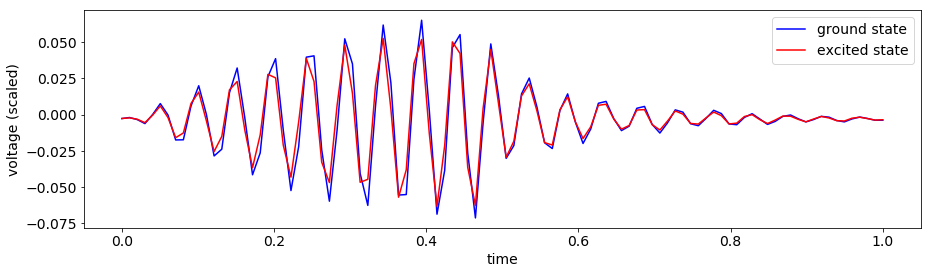

(2, 100)

In [3]:
d_av = np.mean(d_transform, axis=0)
t = np.array(range(len(d_transform[0, 0])))
print(t[0], t[-1])
xf = np.arange(len(t))*1./t[-1]
print(xf[0], xf[-1])
# plot average signals
plt.figure(figsize=(15,4))
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.xlabel("time", fontsize=14)
plt.ylabel("voltage (scaled)", fontsize=14)
plt.plot(xf, d_av[0], "b-", label="ground state")
plt.plot(xf, d_av[1], "r-", label="excited state")
plt.legend(loc="best", fontsize=14)
plt.show()
d_av.shape

## Demodulation (for a given set of parameters)


In [4]:
d = d_transform
#Construction of the demodulation weight function w(t) = x + iy 
x = (d_av[1]-d_av[0])/2.
y = np.real(np.fft.irfft(np.fft.rfft(x, axis = -1)*1j,x.shape[0], axis = -1)) 
#Normalazing : actual axis not calibrated for this experiment
x = x/np.sqrt(np.sum(x**2))
y = y/np.sqrt(np.sum(y**2))
#Demodulation
dIQ = d*(x+1j*y)
dint = np.average(dIQ,axis = -1)
dint = dint.T
dint.shape

(2, 200000)

In [5]:
# Histogram functions
a = np.amax(np.abs(dint)) #fixing the range
r = [[-a,a],[-a,a]]
def hist(dint,ge):
    h = np.histogram2d(np.real(dint[ge]),np.imag(dint[ge]), bins = 50, normed = False, range = r)[0]
    return h    
def ol(dint): # 2d scalar product
    Pg = hist(dint,0)
    Pe = hist(dint,1)
    o = np.sum(Pg*Pe)/(np.sqrt(np.sum(Pg**2))*np.sqrt(np.sum(Pe**2)))
    return o
print("Overlap : "+str(ol(dint)*100) +"%")
def Z(data,ge): #Defining the zone associated with either g or e
    z = hist(data,ge) >  hist(data,1-ge)
    z = z + (hist(data,ge) ==  hist(data,1-ge))*0.5
    return z
def ol_z(data,ge): #Computation of the error
    o = np.sum(Z(data,ge)*hist(data,ge))/np.sum(hist(data,ge))
    return o
print("Error by zone, g: "+str((1-ol_z(dint,0))*100) +"%, e: "+str((1-ol_z(dint,1))*100) +"%")
fidelity = ((ol_z(dint,0)) + (ol_z(dint,1)))/2 * 100
print("Fidelity: " + str(fidelity) + "%" )

Overlap : 90.6024849955735%
Error by zone, g: 16.509249999999998%, e: 53.92675%
Fidelity: 64.78200000000001%


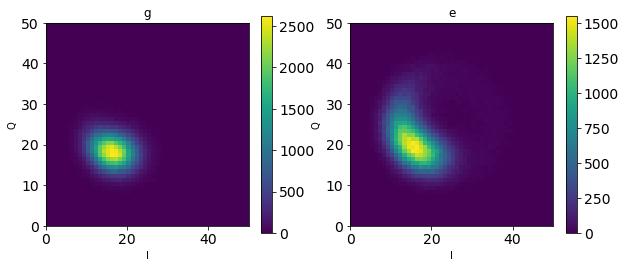

In [6]:
# make plot with 2 subplots
fig, ax = plt.subplots(1,2, figsize=(10, 4))
# subplot 1
plot = ax[0].pcolormesh(hist(dint,0)) # histogram for ground state
fig.colorbar(plot,ax=ax[0],orientation="vertical")
ax[0].set_xlabel("I") # Re[\beta], see Eq. (2)
ax[0].set_ylabel("Q") # Im[\beta], see Eq. (2)
ax[0].set_title("g")  # ground state label
ax[0].axis("tight")   # save space
ax[0].set_aspect(1)   # aspect ratio
# subplot 2
plot = ax[1].pcolormesh(hist(dint,1)) # histogram for excited state; as above
fig.colorbar(plot,ax=ax[1],orientation="vertical")
ax[1].set_xlabel("I") # Re[\beta], see Eq. (2)
ax[1].set_ylabel("Q") # Im[\beta], see Eq. (2)
ax[1].set_title("e")  # excited state label
ax[1].axis("tight")   # save space
ax[1].set_aspect(1)
# show all subplots
plt.show()

## Dataset Preparation

In [7]:
d_g = d_transform[:, 0, :]                           # ground state features
class_g = np.array([[0 for i in range(len(d_g))]]).T # ground state labels
d_g = np.concatenate((class_g, d_g), axis=1)         # ground state features, labels
print(d_g.shape)
d_g[0:3, 0:2]

(200000, 101)


array([[ 0.        , -0.00947497],
       [ 0.        ,  0.07355312],
       [ 0.        , -0.01357753]])

In [8]:
d_g = d_transform[:, 0, :]                           # ground state features
class_g = np.array([[0 for i in range(len(d_g))]]).T # ground state labels
d_g = np.concatenate((class_g, d_g), axis=1)         # ground state features, labels
d_e = d_transform[:, 1, :]                           # excited state features
class_e = np.array([[1 for i in range(len(d_e))]]).T # excited state labels
d_e = np.concatenate((class_e, d_e), axis=1)         # excited state features, labels
ge_data = np.concatenate((d_g, d_e), axis=0)         # ground and excited state labels, features
print(ge_data.shape)                                 # instances, label + features
# for np.random.seed, see https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do/21494630
np.random.seed(0)
shuffle_index = np.random.permutation(len(ge_data))  # create a random order (via indices)
print(shuffle_index[:5])                             # show a few randomized indices
first_5_pseudo_random = np.array([242160, 3413, 393024, 247987, 52436])
print(np.linalg.norm(first_5_pseudo_random - shuffle_index[:5]) == 0)
ge_shuffle_data = ge_data[shuffle_index]             # apply the random order
X_data = ge_shuffle_data[:, 1:]                      # select the features ...
Y_data = ge_shuffle_data[:, :1]                      # ... and the labels
print(X_data.shape)    # shape of feature data
print(Y_data.shape)    # shape of label data
print(X_data[:10, :5]) # for the first 10 instances, show the first 5 features, ...
Y_data[:10]            # ... and the according label

(400000, 101)
[242160   3413 393024 247987  52436]
True
(400000, 100)
(400000, 1)
[[ 0.04385836  0.07316239  0.01162393 -0.03096459 -0.0034188 ]
 [ 0.02803419 -0.05655678 -0.09797314 -0.01494506  0.06398047]
 [ 0.02119658  0.02393162  0.04424908 -0.0157265  -0.07238095]
 [-0.05870574  0.05714286  0.00986569  0.00673993  0.03350427]
 [-0.04229548 -0.04678877  0.01924298 -0.02295482 -0.04678877]
 [-0.02881563 -0.05245421  0.03096459  0.0790232   0.00908425]
 [-0.04327228 -0.00830281  0.00771673 -0.01494506  0.02764347]
 [-0.00283272 -0.01221001  0.01103785  0.03838828  0.0206105 ]
 [-0.0254945  -0.01885226  0.01025641  0.04815629 -0.03428571]
 [-0.04444445 -0.00576313  0.05323565  0.00634921 -0.01943834]]


array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [9]:
print(len(Y_data))
split1 = int(0.8 * len(Y_data))
split2 = int(0.8 * split1)
# use test data for evaluation of the final (!) model (after development)
X_test, Y_test = X_data[split1:], Y_data[split1:]
print(X_test.shape, Y_test.shape)
# use validation data for early stopping and evaluation of different models (during development)
X_valid, Y_valid = X_data[split2:split1], Y_data[split2:split1]
print(X_valid.shape, Y_valid.shape)
# use training data for training / fitting different models (during development)
X_train, Y_train = X_data[:split2], Y_data[:split2]
print(X_train.shape, Y_train.shape)
# scaling all data by training set
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)
print(X_train_mean, X_train_std)
X_train = (X_train - X_train_mean) / X_train_std
X_valid = (X_valid - X_train_mean) / X_train_std
X_test  = (X_test  - X_train_mean) / X_train_std

400000
(80000, 100) (80000, 1)
(64000, 100) (64000, 1)
(256000, 100) (256000, 1)
-0.0028560917035001143 0.05106889604001522


## TensorFlow RNN

In [10]:
import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
n_steps = 20
n_inputs = 5
x_valid = X_valid.reshape(-1, n_steps, n_inputs)
y_valid = Y_valid[:, 0]
x_test = X_test.reshape(-1, n_steps, n_inputs)
y_test = Y_test[:, 0]
def next_batch(batch_size):
    shuffle_idx = np.random.permutation(split2)[:batch_size]
    x_batch = X_train[shuffle_idx].reshape(-1, n_steps, n_inputs)
    y_batch = Y_train[shuffle_idx, 0]
    return x_batch, y_batch
next_batch(3)

(array([[[-1.56414087e+00, -1.52559368e-01, -1.06654294e-01,
           1.72601687e-01, -2.86449228e-01],
         [-5.96308570e-01,  1.49649140e-01, -9.82676429e-01,
          -8.10532347e-01,  6.04874629e-01],
         [ 1.84077964e-01, -1.02475612e+00,  3.90650889e-01,
          -7.19325257e-03, -9.90034419e-02],
         [ 3.06491538e-01, -1.70950707e+00, -8.83215447e-01,
           6.01049212e-01, -5.30983495e-02],
         [ 2.10855936e-01, -7.26373032e-01, -1.25428164e+00,
           3.29444075e-01,  1.35848323e+00],
         [ 1.95847172e-02, -2.43633765e+00, -8.41135754e-01,
           5.36016982e-01,  7.65542425e-01],
         [-2.06115312e-01, -2.37895628e+00, -2.69264112e+00,
          -2.06115312e-01,  2.80449361e+00],
         [-3.36783124e-03, -2.05379524e+00,  1.19338677e-02,
           8.65003480e-01,  9.91242489e-01],
         [-1.83162775e-01, -1.47998163e+00, -3.20878052e-01,
           7.42589925e-01,  5.66620389e-01],
         [-4.43291607e-01, -1.14334430e+00,  3

In [11]:
### construction
# architecture
reset_graph()
n_neurons = 150
n_outputs = 2
n_layers = 3                                                                # number of layers in multi_layer_cell
# training details
LR = 0.01              # learning rate
n_early_stopping = 100 # stop after this number of epochs without improvement on validation set
acc_valid_max = 0      # initial value of accuracy maximum
n_epochs = 2000        # number of epochs
batch_size = 256       # batch size
l2_scale = 0.001       # l2 regularization
# network
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])                   # input instances
y = tf.placeholder(tf.int32, [None])                                        # input classes
lr = tf.placeholder(tf.float32)                                             # placeholder for learning rate
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons)                       # build layers and put ...
          for layer in range(n_layers)]                                     # ... them into "layers"
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers, state_is_tuple=True) # MultiRNNCell
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, x, dtype=tf.float32)  # use dynamic_rnn to automatically ...
                                                                            # ... feed output as the next input
logits = tf.layers.dense(states[-1], n_outputs)                             # last step (automatic), highest layer
# cost function and training
regularize_these = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,      # use ".*kernel.*|.*diag.*" ... 
                                     scope=".*kernel.*|.*diag.*")           # ... (or just ".*kernel.*")
[print(i) for i in regularize_these]                                        # regularize these
print()
l2_loss = l2_scale * sum([tf.reduce_sum(tf.square(i)) for i in regularize_these])
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits) # cross entropy
loss = l2_loss + tf.reduce_mean(xentropy)                                         # loss = average xentropy over batch
optimizer = tf.train.AdamOptimizer(learning_rate=lr)                              # adam optimizer
training_op = optimizer.minimize(loss)                                            # minimize the loss
# classification and accuracy
correct = tf.nn.in_top_k(logits, y, 1)                                            # yes or no (1 or 0)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))                           # accuracy = avg of correct (1 or 0)
# initializer and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()
### execution
with tf.Session() as sess:                                                        # start session
    init.run()                                                                    # initialize variables
    for epoch in range(n_epochs):                                                 # loop over epochs
        acc_train = 0
        count = 0
        for iteration in range(split2 // batch_size):                             # loop over iterations (batches)
            x_batch, y_batch = next_batch(batch_size)
            sess.run(training_op, feed_dict={x: x_batch, y: y_batch, lr: LR})     # feed batch to training operation
            acc_train += accuracy.eval(feed_dict={x: x_batch, y: y_batch})
            count += 1
            print("\rEpoch: {:d}/{:d}\tIteration: {:d}/{:d}\tTraining accuracy: {:.4f}".format(
                epoch+1, n_epochs, iteration+1, split2//batch_size, acc_train/count), end="")
        acc_valid = accuracy.eval(feed_dict={x: x_valid , y: y_valid})            # get accuracy on validation set
        print("\tValidation accuracy: {:.4f}".format(acc_valid))                  # print accuracy on validation set
        # learning schedule and early stopping
        if acc_valid > acc_valid_max:
            acc_valid_count = 0
            acc_valid_max = acc_valid
            saver.save(sess, "./RNN_logs/GRU_3/GRU_3")
        else:
            acc_valid_count += 1
        if acc_valid_count == n_early_stopping//2:
            LR /= 4
            print("\nLearning rate: {}".format(LR))
        if acc_valid_count == n_early_stopping:
            print("Early stopping")
            break
    saver.restore(sess, "./RNN_logs/GRU_3/GRU_3")
    print("Restoring the best model before computing the accuracy on the test set.")
    acc_test = accuracy.eval(feed_dict={x: x_test , y: y_test})                   # get accuracy on test set
    print("\nTest accuracy: {:.4f}".format(acc_test))                             # print accuracy on test set

<tf.Variable 'rnn/multi_rnn_cell/cell_0/gru_cell/gates/kernel:0' shape=(155, 300) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_0/gru_cell/candidate/kernel:0' shape=(155, 150) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_1/gru_cell/gates/kernel:0' shape=(300, 300) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_1/gru_cell/candidate/kernel:0' shape=(300, 150) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_2/gru_cell/gates/kernel:0' shape=(300, 300) dtype=float32_ref>
<tf.Variable 'rnn/multi_rnn_cell/cell_2/gru_cell/candidate/kernel:0' shape=(300, 150) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(150, 2) dtype=float32_ref>

Epoch: 1/2000	Iteration: 1000/1000	Training accuracy: 0.6428	Validation accuracy: 0.6434
Epoch: 2/2000	Iteration: 1000/1000	Training accuracy: 0.6558	Validation accuracy: 0.6544
Epoch: 3/2000	Iteration: 1000/1000	Training accuracy: 0.6574	Validation accuracy: 0.6522
Epoch: 4/2000	Iteration: 1000/1000	Training accura

Epoch: 84/2000	Iteration: 1000/1000	Training accuracy: 0.6640	Validation accuracy: 0.6572
Epoch: 85/2000	Iteration: 1000/1000	Training accuracy: 0.6619	Validation accuracy: 0.6626
Epoch: 86/2000	Iteration: 1000/1000	Training accuracy: 0.6628	Validation accuracy: 0.6615
Epoch: 87/2000	Iteration: 1000/1000	Training accuracy: 0.6627	Validation accuracy: 0.6580
Epoch: 88/2000	Iteration: 1000/1000	Training accuracy: 0.6644	Validation accuracy: 0.6649
Epoch: 89/2000	Iteration: 1000/1000	Training accuracy: 0.6638	Validation accuracy: 0.6626
Epoch: 90/2000	Iteration: 1000/1000	Training accuracy: 0.6655	Validation accuracy: 0.6586
Epoch: 91/2000	Iteration: 1000/1000	Training accuracy: 0.6629	Validation accuracy: 0.6563
Epoch: 92/2000	Iteration: 1000/1000	Training accuracy: 0.6654	Validation accuracy: 0.6604
Epoch: 93/2000	Iteration: 1000/1000	Training accuracy: 0.6636	Validation accuracy: 0.6614
Epoch: 94/2000	Iteration: 1000/1000	Training accuracy: 0.6627	Validation accuracy: 0.6645
Epoch: 95/

Epoch: 174/2000	Iteration: 1000/1000	Training accuracy: 0.6690	Validation accuracy: 0.6680
Epoch: 175/2000	Iteration: 1000/1000	Training accuracy: 0.6671	Validation accuracy: 0.6634
Epoch: 176/2000	Iteration: 1000/1000	Training accuracy: 0.6679	Validation accuracy: 0.6625
Epoch: 177/2000	Iteration: 1000/1000	Training accuracy: 0.6663	Validation accuracy: 0.6661
Epoch: 178/2000	Iteration: 1000/1000	Training accuracy: 0.6677	Validation accuracy: 0.6647
Epoch: 179/2000	Iteration: 1000/1000	Training accuracy: 0.6665	Validation accuracy: 0.6669
Epoch: 180/2000	Iteration: 1000/1000	Training accuracy: 0.6669	Validation accuracy: 0.6642
Epoch: 181/2000	Iteration: 1000/1000	Training accuracy: 0.6678	Validation accuracy: 0.6679
Epoch: 182/2000	Iteration: 1000/1000	Training accuracy: 0.6673	Validation accuracy: 0.6580
Epoch: 183/2000	Iteration: 1000/1000	Training accuracy: 0.6685	Validation accuracy: 0.6640
Epoch: 184/2000	Iteration: 1000/1000	Training accuracy: 0.6667	Validation accuracy: 0.6655

Epoch: 264/2000	Iteration: 1000/1000	Training accuracy: 0.6689	Validation accuracy: 0.6679
Epoch: 265/2000	Iteration: 1000/1000	Training accuracy: 0.6679	Validation accuracy: 0.6669
Epoch: 266/2000	Iteration: 1000/1000	Training accuracy: 0.6677	Validation accuracy: 0.6670
Epoch: 267/2000	Iteration: 1000/1000	Training accuracy: 0.6676	Validation accuracy: 0.6678
Epoch: 268/2000	Iteration: 1000/1000	Training accuracy: 0.6680	Validation accuracy: 0.6670
Epoch: 269/2000	Iteration: 1000/1000	Training accuracy: 0.6688	Validation accuracy: 0.6671
Epoch: 270/2000	Iteration: 1000/1000	Training accuracy: 0.6698	Validation accuracy: 0.6675
Epoch: 271/2000	Iteration: 1000/1000	Training accuracy: 0.6690	Validation accuracy: 0.6677
Epoch: 272/2000	Iteration: 1000/1000	Training accuracy: 0.6686	Validation accuracy: 0.6687
Epoch: 273/2000	Iteration: 1000/1000	Training accuracy: 0.6683	Validation accuracy: 0.6647
Epoch: 274/2000	Iteration: 1000/1000	Training accuracy: 0.6695	Validation accuracy: 0.6685

Epoch: 354/2000	Iteration: 1000/1000	Training accuracy: 0.6704	Validation accuracy: 0.6685
Epoch: 355/2000	Iteration: 1000/1000	Training accuracy: 0.6681	Validation accuracy: 0.6681
Epoch: 356/2000	Iteration: 1000/1000	Training accuracy: 0.6694	Validation accuracy: 0.6684
Epoch: 357/2000	Iteration: 1000/1000	Training accuracy: 0.6700	Validation accuracy: 0.6691
Epoch: 358/2000	Iteration: 1000/1000	Training accuracy: 0.6709	Validation accuracy: 0.6682
Epoch: 359/2000	Iteration: 1000/1000	Training accuracy: 0.6700	Validation accuracy: 0.6688
Epoch: 360/2000	Iteration: 1000/1000	Training accuracy: 0.6701	Validation accuracy: 0.6683
Epoch: 361/2000	Iteration: 1000/1000	Training accuracy: 0.6709	Validation accuracy: 0.6687
Epoch: 362/2000	Iteration: 1000/1000	Training accuracy: 0.6667	Validation accuracy: 0.6688
Epoch: 363/2000	Iteration: 1000/1000	Training accuracy: 0.6692	Validation accuracy: 0.6684
Epoch: 364/2000	Iteration: 1000/1000	Training accuracy: 0.6696	Validation accuracy: 0.6686

The final result (66.9%) is more than 2% better than the one that has been found via the histogram functions (<64.8%, see further above).